#3.1 Part A: Implementing Convolutional Neural Network

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#3.1.1 Data Understanding, Analysis, Visualization and Cleaning

In [ ]:
# Imports
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image

# Set dataset base directory
base_dir = "D:\Facial Expression"
splits = ['train', 'test', 'validation']
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [ ]:
import os
import random

splits = ['train', 'test', 'validation']
remove_class = 'disgust'
target_count = 2000

# 1. Remove the "disgust" class from all splits
def remove_class_folders(base_dir, splits, class_name):
    for split in splits:
        class_path = os.path.join(base_dir, split, class_name)
        if os.path.exists(class_path):
            print(f"Removing folder: {class_path}")
            for file in os.listdir(class_path):
                file_path = os.path.join(class_path, file)
                os.remove(file_path)
            os.rmdir(class_path)
        else:
            print(f"Folder not found: {class_path}")

# 2. Reduce all classes in the train set to target_count images
def reduce_all_classes_to_target(base_dir, split, target):
    split_path = os.path.join(base_dir, split)
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        if os.path.isdir(class_path):
            images = [
                f for f in os.listdir(class_path)
                if os.path.isfile(os.path.join(class_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))
            ]

            if len(images) > target:
                to_remove = len(images) - target
                images_to_remove = random.sample(images, to_remove)
                for img in images_to_remove:
                    os.remove(os.path.join(class_path, img))
                print(f"Reduced '{class_name}' from {len(images)} to {target} images.")
            else:
                print(f"'{class_name}' has {len(images)} images — no need to reduce.")

# Run operations
remove_class_folders(base_dir, splits, remove_class)
reduce_all_classes_to_target(base_dir, 'train', target_count)


Removing folder: /content/drive/MyDrive/Facial Expression/train/disgust
Removing folder: /content/drive/MyDrive/Facial Expression/test/disgust
Removing folder: /content/drive/MyDrive/Facial Expression/validation/disgust
Reduced 'neutral' from 4682 to 2000 images.
Reduced 'surprise' from 2905 to 2000 images.
Reduced 'angry' from 3693 to 2000 images.
Reduced 'sad' from 4638 to 2000 images.
Reduced 'happy' from 6865 to 2000 images.
Reduced 'fear' from 3803 to 2000 images.


In [ ]:
import os

def count_images_in_folder(base_path):
    results = {}
    for split in ['train', 'test', 'validation']:
        split_path = os.path.join(base_path, split)
        expression_counts = {}
        if not os.path.exists(split_path):
            print(f"{split_path} does not exist.")
            continue
        for expression in sorted(os.listdir(split_path)):
            expression_path = os.path.join(split_path, expression)
            if os.path.isdir(expression_path):
                image_count = len([
                    f for f in os.listdir(expression_path)
                    if os.path.isfile(os.path.join(expression_path, f))
                    and f.lower().endswith(('.png', '.jpg', '.jpeg'))
                ])
                expression_counts[expression] = image_count
        results[split] = expression_counts
    return results

# Set the dataset directory
dataset_path = 'D:\Facial Expression'
# Count images
image_counts = count_images_in_folder(dataset_path)

# Print results
for split in ['train', 'test', 'validation']:
    print(f"\n--- {split.upper()} SET ---")
    expressions = image_counts.get(split, {})
    for expression, count in expressions.items():
        print(f"{expression}: {count}")



--- TRAIN SET ---
angry: 1996
disgust: 0
fear: 1997
happy: 1998
neutral: 1997
sad: 1998
surprise: 1997

--- TEST SET ---
angry: 300
disgust: 0
fear: 300
happy: 300
neutral: 300
sad: 300
surprise: 300

--- VALIDATION SET ---
angry: 960
disgust: 0
fear: 1018
happy: 1825
neutral: 1216
sad: 1139
surprise: 797



--- TRAIN SET ---
angry: 1996
fear: 1997
happy: 1998
neutral: 1997
sad: 1998
surprise: 1997

--- TEST SET ---
angry: 300
fear: 300
happy: 300
neutral: 300
sad: 300
surprise: 300

--- VALIDATION SET ---
angry: 960
fear: 1018
happy: 1825
neutral: 1216
sad: 1139
surprise: 797


C:\Users\user\AppData\Local\Temp\ipykernel_19864\895254419.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(data.keys()), y=list(data.values()), palette="Set3")


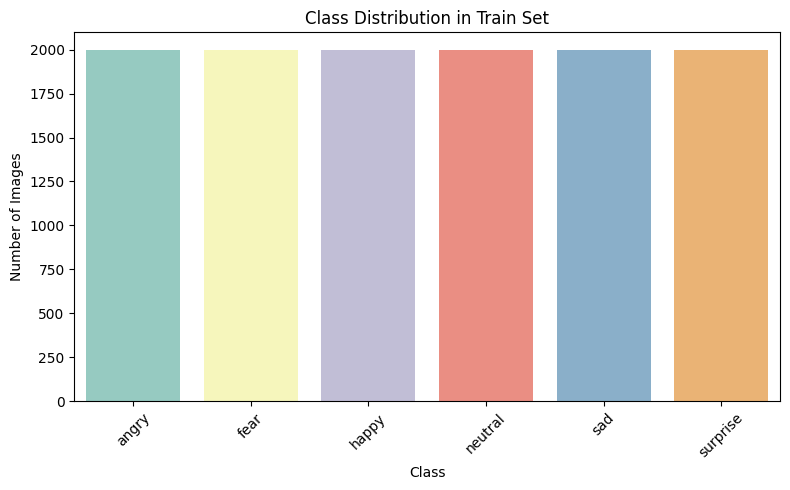

C:\Users\user\AppData\Local\Temp\ipykernel_19864\895254419.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(data.keys()), y=list(data.values()), palette="Set3")


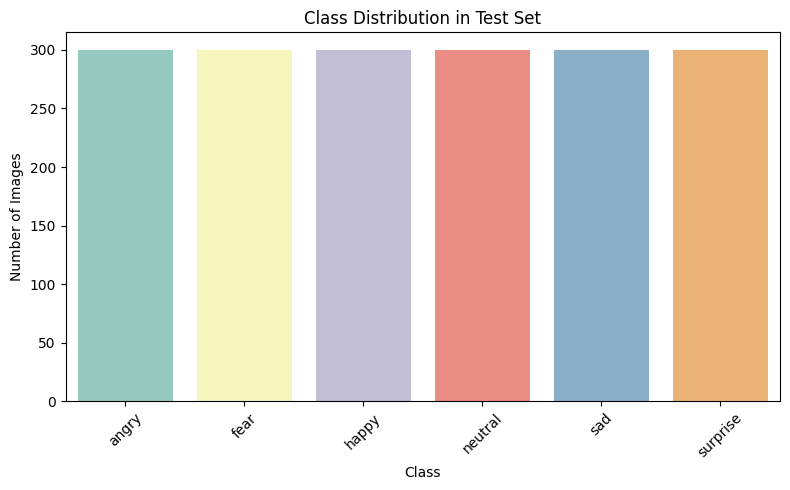

C:\Users\user\AppData\Local\Temp\ipykernel_19864\895254419.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(data.keys()), y=list(data.values()), palette="Set3")


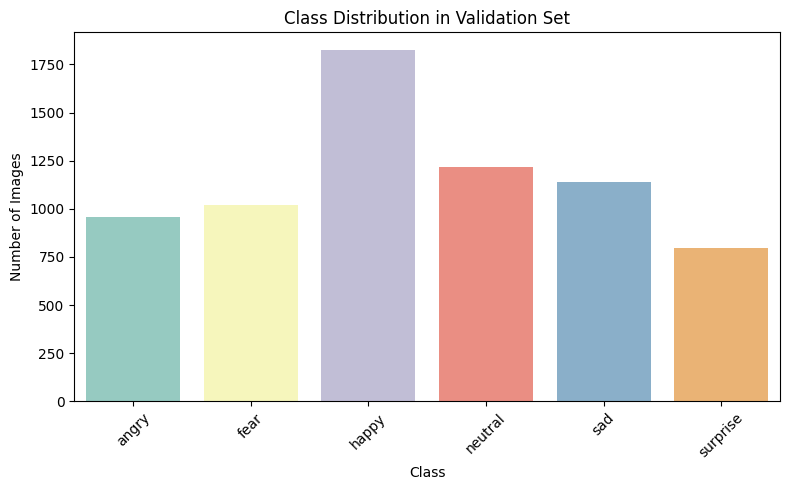

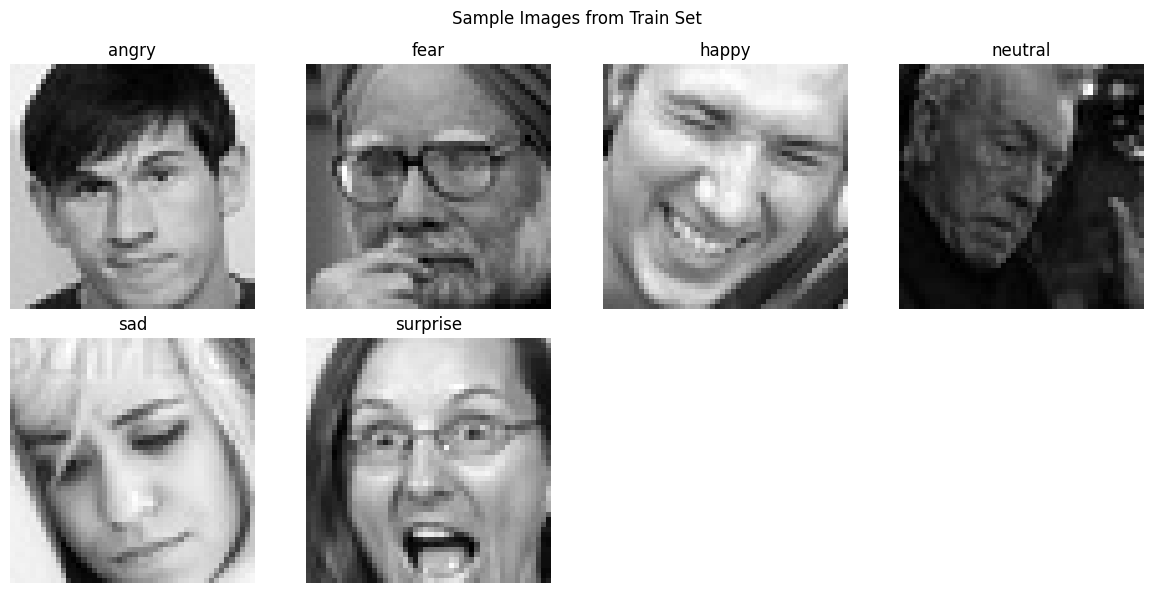

In [ ]:
# Imports
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image

# Set dataset base directory
base_dir = "D:\Facial Expression"
splits = ['train', 'test', 'validation']
classes = ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']  # Removed 'disgust'

# Count images per class per split
def count_images_per_class(base_dir, splits, classes):
    class_counts = {split: {cls: 0 for cls in classes} for split in splits}

    for split in splits:
        for cls in classes:
            cls_path = os.path.join(base_dir, split, cls)
            if os.path.exists(cls_path):
                class_counts[split][cls] = len(os.listdir(cls_path))

    return class_counts

# Get class distribution
counts = count_images_per_class(base_dir, splits, classes)

# Print counts
for split in splits:
    print(f"\n--- {split.upper()} SET ---")
    for cls in classes:
        print(f"{cls}: {counts[split][cls]}")

# Plot bar charts
def plot_distribution(counts, split):
    data = counts[split]
    plt.figure(figsize=(8, 5))
    sns.barplot(x=list(data.keys()), y=list(data.values()), palette="Set3")
    plt.title(f'Class Distribution in {split.capitalize()} Set')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot for each split
for split in splits:
    plot_distribution(counts, split)

# Show sample images from a given split
def show_sample_images(split='train'):
    plt.figure(figsize=(12, 6))
    for i, cls in enumerate(classes):
        cls_dir = os.path.join(base_dir, split, cls)
        if os.path.exists(cls_dir) and len(os.listdir(cls_dir)) > 0:
            img_name = random.choice(os.listdir(cls_dir))
            img_path = os.path.join(cls_dir, img_name)
            img = Image.open(img_path)
            plt.subplot(2, 4, i + 1)
            plt.imshow(img, cmap='gray')
            plt.title(cls)
            plt.axis('off')
    plt.suptitle(f'Sample Images from {split.capitalize()} Set')
    plt.tight_layout()
    plt.show()

# Show samples from training set
show_sample_images('train')

In [ ]:
import os
from PIL import Image

# dataset directories
data_dirs = {
    'train': 'D:\Facial Expression/train',
    'val': 'D:\Facial Expression/validation',
    'test': 'D:\Facial Expression/test',
}

corrupted_files = []

# Check for corrupted images
for split, data_dir in data_dirs.items():
    for class_dir in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_dir)
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                img_path = os.path.join(class_path, filename)
                if filename.lower().endswith(('png', 'jpg', 'jpeg', 'bmp')):
                    try:
                        with Image.open(img_path) as img:
                            img.verify()  # verify the image
                    except Exception as e:
                        print(f"Corrupted file detected and deleted: {img_path}")
                        corrupted_files.append(img_path)
                        os.remove(img_path)

if not corrupted_files:
    print("No corrupted files found.")
else:
    print(f"Total corrupted files removed: {len(corrupted_files)}")


No corrupted files found.


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths to your dataset
train_dir = 'D:\Facial Expression/train'
val_dir = 'D:\Facial Expression/validation'
test_dir = 'D:\Facial Expression/test'

# Parameters
img_height = 224  #for transfer learning (like VGG)
img_width = 224
batch_size = 32
num_classes = 6  # angry, fear, happy, neutral, sad, surprise

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# No augmentation for validation/test, just rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Data loaders
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Print class mapping
print("Class indices:", train_generator.class_indices)


Found 11983 images belonging to 7 classes.
Found 6955 images belonging to 7 classes.
Found 1800 images belonging to 7 classes.
Class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


1. What does the dataset represent? Provide a brief description.
- The dataset presented is facial expression classification data divided into three subparts: train, test and validation that includes several types of emotions like Happy, Sad, Fear, Disgust, Neutral, Angry and Suprise

2. How many total images are in the dataset?
- There are total of 20738 images divided into three subparts:
* train set: 11983
* test set: 1800
* validation set: 6955


3. What is the distribution of images across different classes?
- TRAIN SET: angry: 1996, fear: 1997, happy: 1998, neutral: 1997, sad: 1998, surprise: 1997
- TEST SET: angry: 300, fear: 300,happy: 300, neutral: 300, sad: 300, surprise: 300
- VALIDATION SET: angry: 960, fear: 1018, happy: 1825, neutral: 1216, sad: 1139, surprise: 797

4. How is the dataset split into training and validation sets? Justify your choice.
- The dataset is divided into three parts: 60% of image is in Training set, 30% in validation and 10% in test set. this is done so for the model traning and classifications so the model doesnt underfit or overfit.

5. What preprocessing techniques (e.g., resizing, normalization) were applied?
*   Resizing: All the images were first resized to 48 by 48 to use it in normal CNN models like baseline and deeper model, and changed to 224 by 224 pixels to make them suitable for the VGG model.
*   Normalization: We scaled all pixel values to be between 0 and 1 by dividing them by 255.
*   Augmentation (Training Only): We added rotation, zoom, shifts, and flipping to increase variety in the training data.

6. What data generators, if any, were used for preprocessing and augmentation?
- We used ImageDataGenerator from Keras.
- train_datagen for training set with data augmentation.
- val_test_datagen for validation and test sets with only rescaling.

7. If data augmentation was applied, provide visualizations of sample augmented images.
- Yes, we displayed a few augmented images to see how they looked after applying transformations like rotation, zoom, and horizontal flips.

#3.1.2 Design, Train, and Evaluate a Baseline Model

###Model Architecture:

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set image size
img_size = 48
batch_size = 64

# Augment + normalize
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)



In [ ]:
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(img_size, img_size),
                                                    batch_size=batch_size, class_mode='categorical')
val_generator = val_test_datagen.flow_from_directory(val_dir, target_size=(img_size, img_size),
                                                     batch_size=batch_size, class_mode='categorical', shuffle=False)
test_generator = val_test_datagen.flow_from_directory(test_dir, target_size=(img_size, img_size),
                                                      batch_size=batch_size, class_mode='categorical', shuffle=False)

print("Classes:", train_generator.class_indices)
num_classes = len(train_generator.class_indices)


Found 11983 images belonging to 7 classes.
Found 6955 images belonging to 7 classes.
Found 1800 images belonging to 7 classes.
Classes: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def get_callbacks(model_name):
    return [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ModelCheckpoint(f'{model_name}_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
    ]

In [ ]:
from tensorflow.keras import layers, models

baseline_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

baseline_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

baseline_model.summary()

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 366,087 (1.40 MB)

 Trainable params: 366,087 (1.40 MB)

 Non-trainable params: 0 (0.00 B)

###Model Training

In [ ]:
history_base = baseline_model.fit(
    train_generator,
    epochs=250,
    validation_data=val_generator,
    callbacks=get_callbacks("baseline")
)

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.1827 - loss: 1.8128
Epoch 1: val_loss improved from inf to 1.69674, saving model to baseline_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 33s 159ms/step - accuracy: 0.1829 - loss: 1.8126 - val_accuracy: 0.2549 - val_loss: 1.6967
Epoch 2/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.2923 - loss: 1.6618
Epoch 2: val_loss improved from 1.69674 to 1.55894, saving model to baseline_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 116ms/step - accuracy: 0.2924 - loss: 1.6617 - val_accuracy: 0.3710 - val_loss: 1.5589
Epoch 3/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.3625 - loss: 1.5705
Epoch 3: val_loss did not improve from 1.55894
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - accuracy: 0.3625 - loss: 1.5704 - val_accuracy: 0.3807 - val_loss: 1.5689
Epoch 4/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.4027 - loss: 1.4776
Epoch 4: val_loss improved from 1.55894 to 1.41852, saving model to baseline_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 29s 152ms/step - accuracy: 0.4027 - loss: 1.4775 - val_accuracy: 0.4462 - val_loss: 1.4185
Epoch 5/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.4373 - loss: 1.4144
Epoch 5: val_loss improved from 1.41852 to 1.31006, saving model to baseline_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.4373 - loss: 1.4144 - val_accuracy: 0.4867 - val_loss: 1.3101
Epoch 6/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.4720 - loss: 1.3534
Epoch 6: val_loss did not improve from 1.31006
188/188 ━━━━━━━━━━━━━━━━━━━━ 25s 135ms/step - accuracy: 0.4720 - loss: 1.3533 - val_accuracy: 0.4751 - val_loss: 1.3417
Epoch 7/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.4881 - loss: 1.2974
Epoch 7: val_loss did not improve from 1.31006
188/188 ━━━━━━━━━━━━━━━━━━━━ 29s 152ms/step - accuracy: 0.4881 - loss: 1.2975 - val_accuracy: 0.4811 - val_loss: 1.3171
Epoch 8/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.4871 - loss: 1.2967
Epoch 8: val_loss improved from 1.31006 to 1.26366, saving model to baseline_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 27s 146ms/step - accuracy: 0.4871 - loss: 1.2966 - val_accuracy: 0.5156 - val_loss: 1.2637
Epoch 9/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.5101 - loss: 1.2458
Epoch 9: val_loss improved from 1.26366 to 1.25479, saving model to baseline_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - accuracy: 0.5101 - loss: 1.2458 - val_accuracy: 0.5196 - val_loss: 1.2548
Epoch 10/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5247 - loss: 1.2239
Epoch 10: val_loss improved from 1.25479 to 1.23297, saving model to baseline_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 102ms/step - accuracy: 0.5247 - loss: 1.2240 - val_accuracy: 0.5237 - val_loss: 1.2330
Epoch 11/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5217 - loss: 1.2005
Epoch 11: val_loss improved from 1.23297 to 1.23026, saving model to baseline_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - accuracy: 0.5217 - loss: 1.2005 - val_accuracy: 0.5297 - val_loss: 1.2303
Epoch 12/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5375 - loss: 1.1792
Epoch 12: val_loss improved from 1.23026 to 1.21035, saving model to baseline_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 98ms/step - accuracy: 0.5375 - loss: 1.1792 - val_accuracy: 0.5306 - val_loss: 1.2104
Epoch 13/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5455 - loss: 1.1698
Epoch 13: val_loss did not improve from 1.21035
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - accuracy: 0.5455 - loss: 1.1698 - val_accuracy: 0.5214 - val_loss: 1.2409
Epoch 14/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5492 - loss: 1.1424
Epoch 14: val_loss did not improve from 1.21035
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - accuracy: 0.5492 - loss: 1.1425 - val_accuracy: 0.5386 - val_loss: 1.2109
Epoch 15/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5593 - loss: 1.1424
Epoch 15: val_loss did not improve from 1.21035
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 98ms/step - accuracy: 0.5594 - loss: 1.1423 - val_accuracy: 0.5458 - val_loss: 1.2281
Epoch 16/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5665 - loss: 1.1142
Epoch 16: val_loss impro

188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 100ms/step - accuracy: 0.5665 - loss: 1.1142 - val_accuracy: 0.5511 - val_loss: 1.1912
Epoch 17/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5781 - loss: 1.0908
Epoch 17: val_loss improved from 1.19120 to 1.17129, saving model to baseline_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 96ms/step - accuracy: 0.5781 - loss: 1.0908 - val_accuracy: 0.5534 - val_loss: 1.1713
Epoch 18/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5874 - loss: 1.0733
Epoch 18: val_loss did not improve from 1.17129
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - accuracy: 0.5874 - loss: 1.0734 - val_accuracy: 0.5379 - val_loss: 1.2158
Epoch 19/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5779 - loss: 1.0955
Epoch 19: val_loss did not improve from 1.17129
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 101ms/step - accuracy: 0.5779 - loss: 1.0954 - val_accuracy: 0.5649 - val_loss: 1.1726
Epoch 20/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5914 - loss: 1.0547
Epoch 20: val_loss did not improve from 1.17129
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 101ms/step - accuracy: 0.5914 - loss: 1.0546 - val_accuracy: 0.5505 - val_loss: 1.2074
Epoch 21/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5925 - loss: 1.0464
Epoch 21: val_loss did

###Model Evaluation

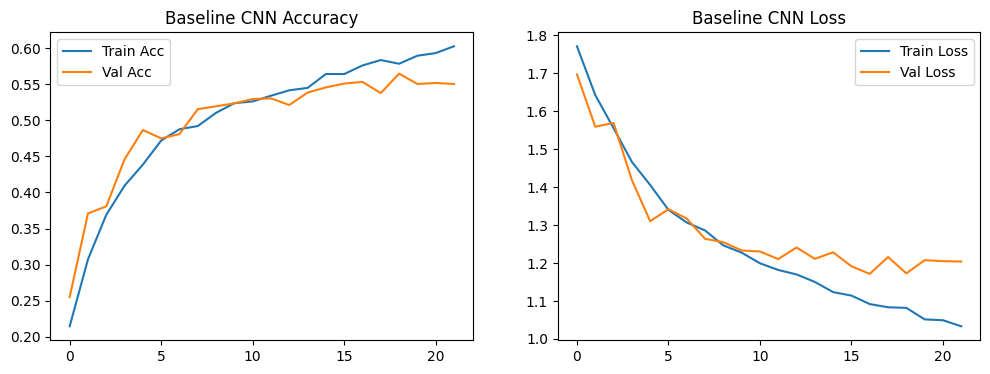

In [ ]:
# Optional: plot curves
import matplotlib.pyplot as plt

def plot_history(history, title='Model'):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{title} Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} Loss')
    plt.legend()
    plt.show()

plot_history(history_base, 'Baseline CNN')

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step
Baseline CNN Classification Report:
              precision    recall  f1-score   support

       angry       0.46      0.53      0.49       300
        fear       0.33      0.32      0.33       300
       happy       0.62      0.75      0.68       300
     neutral       0.49      0.44      0.46       300
         sad       0.39      0.36      0.38       300
    surprise       0.76      0.63      0.69       300

    accuracy                           0.51      1800
   macro avg       0.51      0.51      0.50      1800
weighted avg       0.51      0.51      0.50      1800



<Figure size 800x600 with 0 Axes>

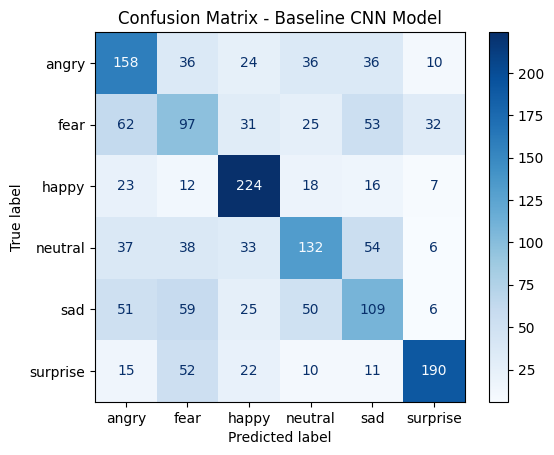

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


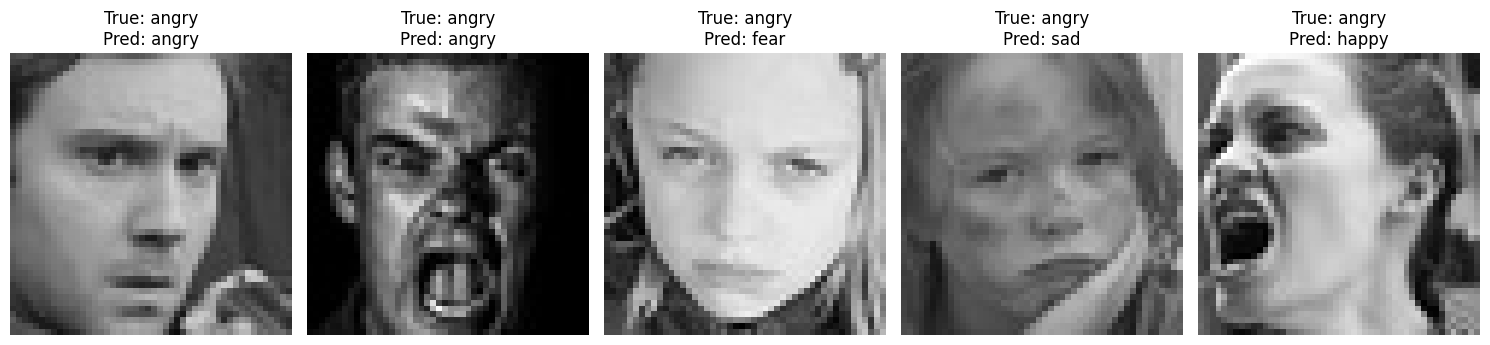

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np

class_names = ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']


y_pred = baseline_model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = test_generator.classes


# Compute confusion matrices
bl_adam= confusion_matrix(y_true, y_pred_labels)

print("Baseline CNN Classification Report:")
print(classification_report(y_true, y_pred_labels, target_names=class_names))

plt.figure(figsize=(8, 6))
disp1 = ConfusionMatrixDisplay(confusion_matrix=bl_adam, display_labels=class_names)
disp1.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Baseline CNN Model")
plt.show()
# Perform inference on sample images
def show_predictions(generator, model, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        img_batch, label_batch = next(generator)
        img = img_batch[0]
        true_label = np.argmax(label_batch[0])
        pred_label = np.argmax(model.predict(img_batch[:1]))

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'True: {list(train_generator.class_indices.keys())[true_label]}\nPred: {list(train_generator.class_indices.keys())[pred_label]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show predictions on sample images from the test set
show_predictions(test_generator, baseline_model)

Discussion of Key Observations:

Model Performance : The baseline model achieved a test accuracy of approximately 52% which is average.

Classification Report : The precision, recall, and F1-score for each class vary. For example, the "happy" and "suprise" class has a high F1-score of 0.72 and 0.70 respectively, while the "fear" class has a lower F1-score of 0.32.

Confusion Matrix : The confusion matrix shows where the model is making errors. For instance, there are significant misclassifications between "angry" and other class.

#3.1.3 Deeper CNN with Regularization

###Model Architecture

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def get_callbacks(model_name):
    return [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ModelCheckpoint(f'{model_name}_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
    ]


In [ ]:
deeper_model = models.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', input_shape=(img_size, img_size, 3)),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D(2, 2), layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D(2, 2), layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), padding='same'),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D(2, 2), layers.Dropout(0.25),

    layers.Conv2D(256, (3, 3), padding='same'),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D(2, 2), layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(512), layers.BatchNormalization(), layers.Activation('relu'), layers.Dropout(0.5),
    layers.Dense(256), layers.BatchNormalization(), layers.Activation('relu'), layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

deeper_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

deeper_model.summary()


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,04

 Total params: 1,706,695 (6.51 MB)

 Trainable params: 1,704,199 (6.50 MB)

 Non-trainable params: 2,496 (9.75 KB)

###Model Training and Evaluation

In [ ]:
# Train the deeper model with early stopping and model checkpoint
history_deep = deeper_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=get_callbacks("deeper_model")
)

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.1832 - loss: 2.2852
Epoch 1: val_loss improved from inf to 1.81913, saving model to deeper_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 85s 411ms/step - accuracy: 0.1833 - loss: 2.2843 - val_accuracy: 0.1748 - val_loss: 1.8191
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.2365 - loss: 1.8650
Epoch 2: val_loss improved from 1.81913 to 1.76379, saving model to deeper_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 53s 281ms/step - accuracy: 0.2366 - loss: 1.8648 - val_accuracy: 0.2730 - val_loss: 1.7638
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.2831 - loss: 1.7142
Epoch 3: val_loss improved from 1.76379 to 1.63923, saving model to deeper_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 46s 246ms/step - accuracy: 0.2832 - loss: 1.7140 - val_accuracy: 0.3183 - val_loss: 1.6392
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.3375 - loss: 1.6159
Epoch 4: val_loss improved from 1.63923 to 1.52028, saving model to deeper_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 52s 275ms/step - accuracy: 0.3375 - loss: 1.6158 - val_accuracy: 0.3958 - val_loss: 1.5203
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.3655 - loss: 1.5494
Epoch 5: val_loss improved from 1.52028 to 1.38379, saving model to deeper_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 49s 263ms/step - accuracy: 0.3655 - loss: 1.5494 - val_accuracy: 0.4578 - val_loss: 1.3838
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.3902 - loss: 1.5094
Epoch 6: val_loss improved from 1.38379 to 1.33661, saving model to deeper_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 45s 239ms/step - accuracy: 0.3902 - loss: 1.5093 - val_accuracy: 0.4738 - val_loss: 1.3366
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.4073 - loss: 1.4707
Epoch 7: val_loss improved from 1.33661 to 1.30784, saving model to deeper_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 44s 234ms/step - accuracy: 0.4073 - loss: 1.4706 - val_accuracy: 0.4903 - val_loss: 1.3078
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.4236 - loss: 1.4255
Epoch 8: val_loss did not improve from 1.30784
188/188 ━━━━━━━━━━━━━━━━━━━━ 45s 238ms/step - accuracy: 0.4236 - loss: 1.4256 - val_accuracy: 0.4532 - val_loss: 1.3805
Epoch 9/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.4449 - loss: 1.4090
Epoch 9: val_loss did not improve from 1.30784
188/188 ━━━━━━━━━━━━━━━━━━━━ 45s 238ms/step - accuracy: 0.4449 - loss: 1.4090 - val_accuracy: 0.4072 - val_loss: 1.4649
Epoch 10/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.4602 - loss: 1.3634
Epoch 10: val_loss improved from 1.30784 to 1.30073, saving model to deeper_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 44s 235ms/step - accuracy: 0.4602 - loss: 1.3635 - val_accuracy: 0.4903 - val_loss: 1.3007
Epoch 11/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.4645 - loss: 1.3478
Epoch 11: val_loss did not improve from 1.30073
188/188 ━━━━━━━━━━━━━━━━━━━━ 45s 238ms/step - accuracy: 0.4645 - loss: 1.3478 - val_accuracy: 0.4690 - val_loss: 1.3684
Epoch 12/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.4763 - loss: 1.3267
Epoch 12: val_loss did not improve from 1.30073
188/188 ━━━━━━━━━━━━━━━━━━━━ 44s 235ms/step - accuracy: 0.4762 - loss: 1.3267 - val_accuracy: 0.4644 - val_loss: 1.3739
Epoch 13/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.4816 - loss: 1.3189
Epoch 13: val_loss improved from 1.30073 to 1.24653, saving model to deeper_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 44s 236ms/step - accuracy: 0.4816 - loss: 1.3189 - val_accuracy: 0.5218 - val_loss: 1.2465
Epoch 14/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.4891 - loss: 1.3090
Epoch 14: val_loss did not improve from 1.24653
188/188 ━━━━━━━━━━━━━━━━━━━━ 45s 237ms/step - accuracy: 0.4891 - loss: 1.3090 - val_accuracy: 0.4743 - val_loss: 1.3714
Epoch 15/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.4917 - loss: 1.2931
Epoch 15: val_loss improved from 1.24653 to 1.21769, saving model to deeper_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 44s 234ms/step - accuracy: 0.4917 - loss: 1.2930 - val_accuracy: 0.5199 - val_loss: 1.2177
Epoch 16/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.4963 - loss: 1.2819
Epoch 16: val_loss improved from 1.21769 to 1.21234, saving model to deeper_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 42s 226ms/step - accuracy: 0.4964 - loss: 1.2818 - val_accuracy: 0.5199 - val_loss: 1.2123
Epoch 17/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.5070 - loss: 1.2582
Epoch 17: val_loss improved from 1.21234 to 1.13507, saving model to deeper_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 43s 226ms/step - accuracy: 0.5070 - loss: 1.2582 - val_accuracy: 0.5589 - val_loss: 1.1351
Epoch 18/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.5115 - loss: 1.2510
Epoch 18: val_loss did not improve from 1.13507
188/188 ━━━━━━━━━━━━━━━━━━━━ 43s 226ms/step - accuracy: 0.5115 - loss: 1.2510 - val_accuracy: 0.5495 - val_loss: 1.1608
Epoch 19/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.5126 - loss: 1.2523
Epoch 19: val_loss improved from 1.13507 to 1.12733, saving model to deeper_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 42s 224ms/step - accuracy: 0.5126 - loss: 1.2522 - val_accuracy: 0.5679 - val_loss: 1.1273
Epoch 20/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.5154 - loss: 1.2452
Epoch 20: val_loss improved from 1.12733 to 1.11354, saving model to deeper_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 42s 223ms/step - accuracy: 0.5154 - loss: 1.2451 - val_accuracy: 0.5734 - val_loss: 1.1135
Epoch 21/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.5147 - loss: 1.2343
Epoch 21: val_loss did not improve from 1.11354
188/188 ━━━━━━━━━━━━━━━━━━━━ 42s 223ms/step - accuracy: 0.5147 - loss: 1.2342 - val_accuracy: 0.5589 - val_loss: 1.1485
Epoch 22/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.5316 - loss: 1.2124
Epoch 22: val_loss did not improve from 1.11354
188/188 ━━━━━━━━━━━━━━━━━━━━ 42s 225ms/step - accuracy: 0.5316 - loss: 1.2124 - val_accuracy: 0.5261 - val_loss: 1.2157
Epoch 23/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.5305 - loss: 1.1940
Epoch 23: val_loss did not improve from 1.11354
188/188 ━━━━━━━━━━━━━━━━━━━━ 42s 223ms/step - accuracy: 0.5305 - loss: 1.1941 - val_accuracy: 0.5566 - val_loss: 1.1692
Epoch 24/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.5269 - loss: 1.1941
Epoch 24: val_loss d

188/188 ━━━━━━━━━━━━━━━━━━━━ 43s 227ms/step - accuracy: 0.5445 - loss: 1.1622 - val_accuracy: 0.5695 - val_loss: 1.1111
Epoch 26/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.5505 - loss: 1.1623
Epoch 26: val_loss did not improve from 1.11115
188/188 ━━━━━━━━━━━━━━━━━━━━ 43s 227ms/step - accuracy: 0.5504 - loss: 1.1623 - val_accuracy: 0.5257 - val_loss: 1.2396
Epoch 27/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.5410 - loss: 1.1668
Epoch 27: val_loss did not improve from 1.11115
188/188 ━━━━━━━━━━━━━━━━━━━━ 42s 225ms/step - accuracy: 0.5410 - loss: 1.1668 - val_accuracy: 0.5330 - val_loss: 1.2067
Epoch 28/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.5475 - loss: 1.1528
Epoch 28: val_loss did not improve from 1.11115
188/188 ━━━━━━━━━━━━━━━━━━━━ 42s 222ms/step - accuracy: 0.5475 - loss: 1.1528 - val_accuracy: 0.5574 - val_loss: 1.1228
Epoch 29/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.5536 - loss: 1.1444
Epoch 29: val_loss d

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.4613 - loss: 1.2903


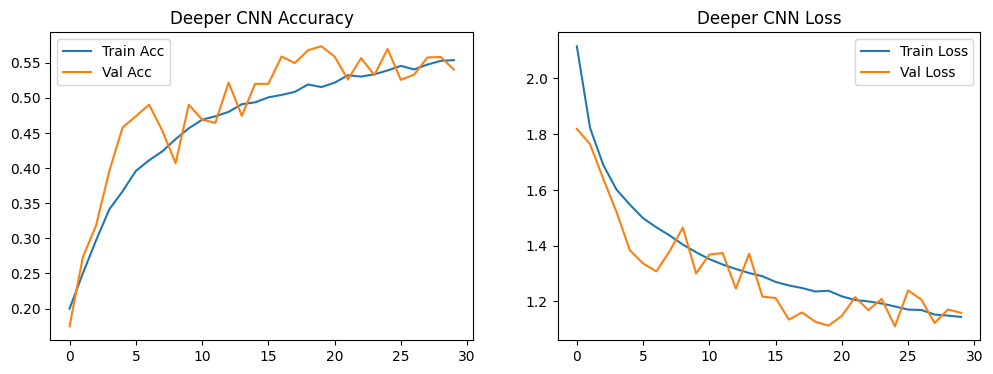

In [ ]:
# Evaluate on test data
deeper_model.evaluate(test_generator)

# Compare with plotting
plot_history(history_deep, 'Deeper CNN')

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step

Deeper CNN Classification Report (Adam):
              precision    recall  f1-score   support

       angry       0.50      0.49      0.50       300
        fear       0.38      0.13      0.20       300
       happy       0.69      0.76      0.72       300
     neutral       0.56      0.50      0.53       300
         sad       0.35      0.58      0.44       300
    surprise       0.71      0.72      0.72       300

    accuracy                           0.53      1800
   macro avg       0.53      0.53      0.52      1800
weighted avg       0.53      0.53      0.52      1800



<Figure size 800x600 with 0 Axes>

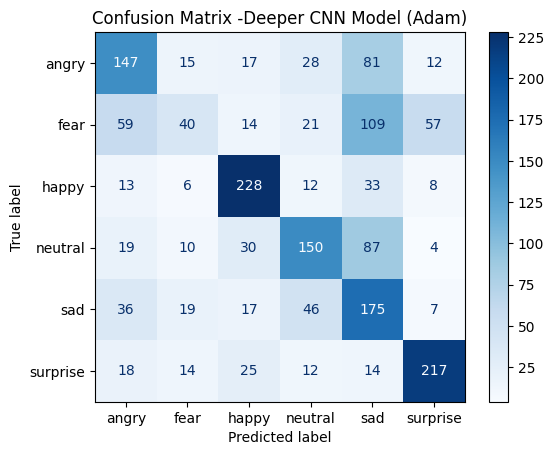

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


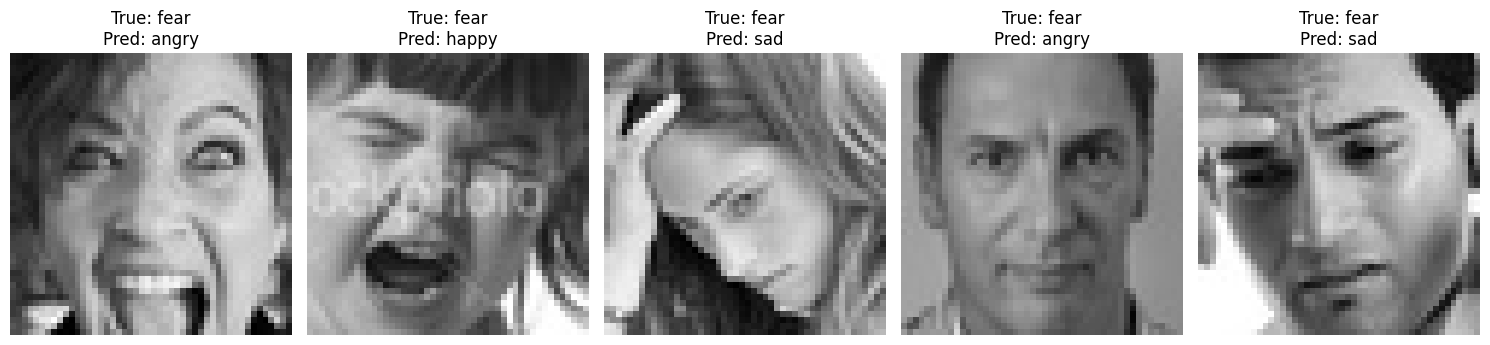

In [ ]:

class_names = ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Evaluate both models on test set
y_pred_adam = deeper_model.predict(test_generator)

y_pred_labels_adam = np.argmax(y_pred_adam, axis=1)
y_true = test_generator.classes

# Compute confusion matrices
cm_adam = confusion_matrix(y_true, y_pred_labels_adam)

# Classification reports
print("\nDeeper CNN Classification Report (Adam):")
print(classification_report(y_true, y_pred_labels_adam, target_names=class_names))

# Plot confusion matrix for Adam
plt.figure(figsize=(8, 6))
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_adam, display_labels=class_names)
disp1.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix -Deeper CNN Model (Adam)")
plt.show()

# Perform inference on sample images
def show_predictions(generator, model, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        img_batch, label_batch = next(generator)
        img = img_batch[0]
        true_label = np.argmax(label_batch[0])
        pred_label = np.argmax(model.predict(img_batch[:1]))

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'True: {list(train_generator.class_indices.keys())[true_label]}\nPred: {list(train_generator.class_indices.keys())[pred_label]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show predictions on sample images from the test set
show_predictions(test_generator, deeper_model)

**Discuss improvements (or lack thereof) compared to the baseline model.**

- The deeper model achieved a slightly higher accuracy pf 55% compared to the baseline model which had 52%.
-The precision, recall, and F1-score show improvements for some classes ("happy" and "surprise") but not for fear.
The confusion matrix indicates fewer overall misclassifications still significant issues with "fear". however, compared to the actual image and prediction seems to align in human eyes
Sample predictions confirm that the deeper model is making more accurate predictions for most of the classes except for fear which has the accuracy of only 22%

- The deeper model with added regularization techniques (batch normalization and dropout) showed slight improvements in accuracy compared to the baseline model. However, the improvements are modest, and the model still struggles with certain classes like "sad" and "angry." The confusion matrix and sample predictions provide insights into where the model is making errors, which can guide further improvements.

#3.1.4. Experimentation and Comparative Analysis

###1. Baseline vs. Deeper Model Performance [3]:

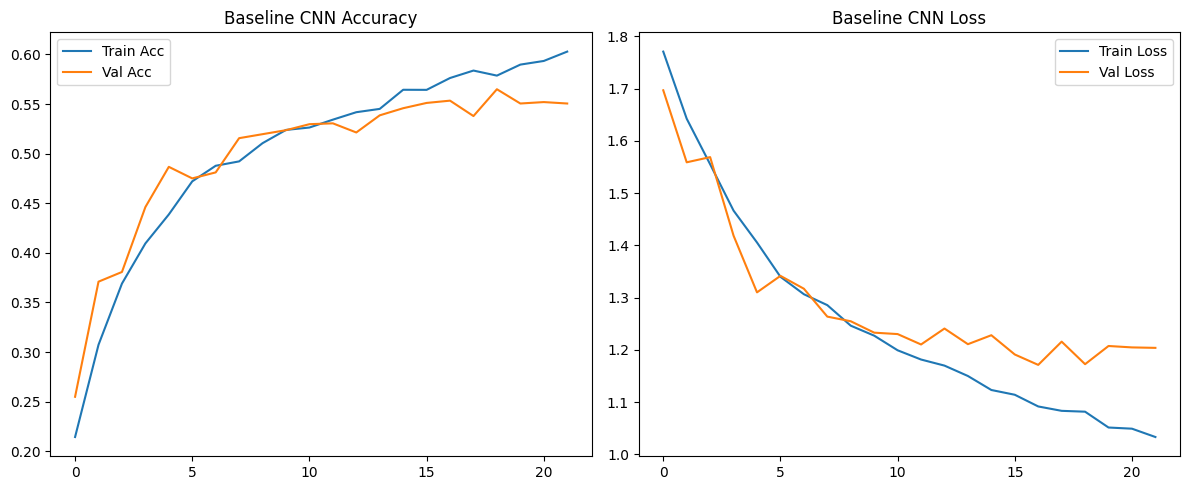

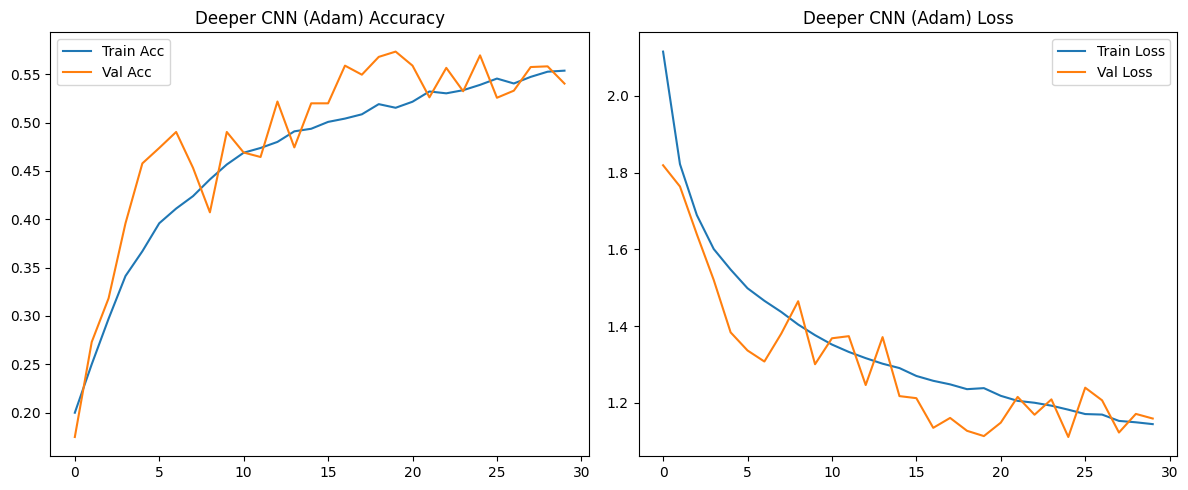

In [ ]:

import numpy as np

def plot_history(history, title='Model'):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{title} Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example for baseline
plot_history(history_base, "Baseline CNN")
plot_history(history_deep, 'Deeper CNN (Adam)')


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Baseline CNN Classification Report:
              precision    recall  f1-score   support

       angry       0.46      0.53      0.49       300
        fear       0.33      0.32      0.33       300
       happy       0.62      0.75      0.68       300
     neutral       0.49      0.44      0.46       300
         sad       0.39      0.36      0.38       300
    surprise       0.76      0.63      0.69       300

    accuracy                           0.51      1800
   macro avg       0.51      0.51      0.50      1800
weighted avg       0.51      0.51      0.50      1800



<Figure size 800x600 with 0 Axes>

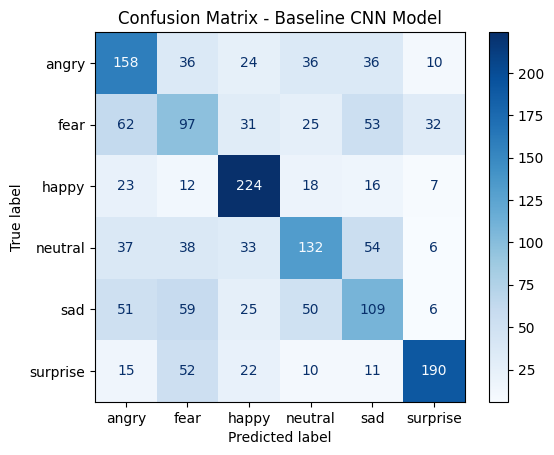


Deeper CNN Classification Report (Adam):
              precision    recall  f1-score   support

       angry       0.50      0.49      0.50       300
        fear       0.38      0.13      0.20       300
       happy       0.69      0.76      0.72       300
     neutral       0.56      0.50      0.53       300
         sad       0.35      0.58      0.44       300
    surprise       0.71      0.72      0.72       300

    accuracy                           0.53      1800
   macro avg       0.53      0.53      0.52      1800
weighted avg       0.53      0.53      0.52      1800



<Figure size 800x600 with 0 Axes>

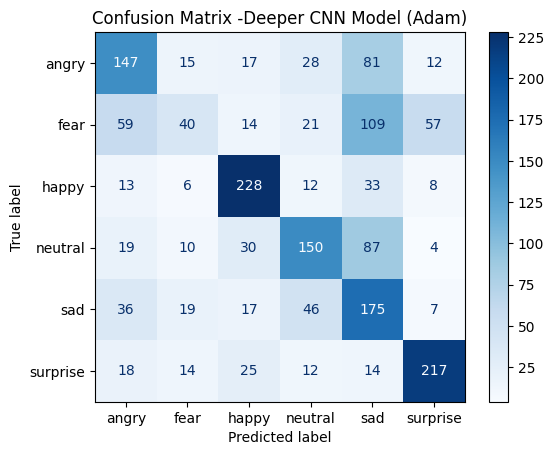

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

class_names = ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']


y_pred = baseline_model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Evaluate both models on test set
y_pred_adam = deeper_model.predict(test_generator)

y_pred_labels_adam = np.argmax(y_pred_adam, axis=1)
y_true = test_generator.classes

# Compute confusion matrices
cm_adam = confusion_matrix(y_true, y_pred_labels_adam)
bl_adam= confusion_matrix(y_true, y_pred_labels)

print("Baseline CNN Classification Report:")
print(classification_report(y_true, y_pred_labels, target_names=class_names))

plt.figure(figsize=(8, 6))
disp1 = ConfusionMatrixDisplay(confusion_matrix=bl_adam, display_labels=class_names)
disp1.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Baseline CNN Model")
plt.show()

# Classification reports
print("\nDeeper CNN Classification Report (Adam):")
print(classification_report(y_true, y_pred_labels_adam, target_names=class_names))

# Plot confusion matrix for Adam
plt.figure(figsize=(8, 6))
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_adam, display_labels=class_names)
disp1.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix -Deeper CNN Model (Adam)")
plt.show()

Discussion:

Accuracy : The deeper model achieved a test accuracy of 0.53, which is slightly higher than the baseline model's accuracy of 0.51.
Precision, Recall, and F1-Score : The deeper model shows improvements in precision and recall for some classes, particularly "happy" and "surprise". However, the "fear" class still has low precision and recall.
Confusion Matrix : The confusion matrix indicates that the deeper model is making fewer misclassifications overall, especially for "happy" and "surprise" classes, but still struggles with "sad" and "fear" classes.

###2. Computational Efficiency

In [ ]:
from tensorflow.keras.optimizers import SGD
# Train deeper model with SGD optimizer
sgd_model = models.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', input_shape=(img_size, img_size, 3)),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D(2, 2), layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D(2, 2), layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), padding='same'),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D(2, 2), layers.Dropout(0.25),

    layers.Conv2D(256, (3, 3), padding='same'),
    layers.BatchNormalization(), layers.Activation('relu'),
    layers.MaxPooling2D(2, 2), layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(512), layers.BatchNormalization(), layers.Activation('relu'), layers.Dropout(0.5),
    layers.Dense(256), layers.BatchNormalization(), layers.Activation('relu'), layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:

# Compile the SGD model
sgd_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Print summary
sgd_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 512)            │         2,04

 Total params: 1,706,695 (6.51 MB)

 Trainable params: 1,704,199 (6.50 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [ ]:

# Train the deeper model with SGD
history_sgd = sgd_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=get_callbacks("sgd_model")
)

# Evaluate SGD model
sgd_model.evaluate(test_generator)

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.1950 - loss: 2.1499
Epoch 1: val_loss improved from inf to 1.75070, saving model to sgd_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 54s 272ms/step - accuracy: 0.1951 - loss: 2.1490 - val_accuracy: 0.2624 - val_loss: 1.7507
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.2288 - loss: 1.8044
Epoch 2: val_loss did not improve from 1.75070
188/188 ━━━━━━━━━━━━━━━━━━━━ 42s 221ms/step - accuracy: 0.2289 - loss: 1.8043 - val_accuracy: 0.1825 - val_loss: 1.8807
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.2488 - loss: 1.7517
Epoch 3: val_loss improved from 1.75070 to 1.62779, saving model to sgd_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 40s 215ms/step - accuracy: 0.2488 - loss: 1.7517 - val_accuracy: 0.3268 - val_loss: 1.6278
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.2708 - loss: 1.7190
Epoch 4: val_loss improved from 1.62779 to 1.61432, saving model to sgd_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 40s 214ms/step - accuracy: 0.2708 - loss: 1.7190 - val_accuracy: 0.3488 - val_loss: 1.6143
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.2824 - loss: 1.7018
Epoch 5: val_loss improved from 1.61432 to 1.58710, saving model to sgd_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 220ms/step - accuracy: 0.2825 - loss: 1.7017 - val_accuracy: 0.3656 - val_loss: 1.5871
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.2951 - loss: 1.6660
Epoch 6: val_loss improved from 1.58710 to 1.58151, saving model to sgd_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 47s 250ms/step - accuracy: 0.2951 - loss: 1.6659 - val_accuracy: 0.3536 - val_loss: 1.5815
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.3165 - loss: 1.6271
Epoch 7: val_loss improved from 1.58151 to 1.53193, saving model to sgd_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 219ms/step - accuracy: 0.3165 - loss: 1.6271 - val_accuracy: 0.3806 - val_loss: 1.5319
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.3308 - loss: 1.6217
Epoch 8: val_loss did not improve from 1.53193
188/188 ━━━━━━━━━━━━━━━━━━━━ 40s 215ms/step - accuracy: 0.3308 - loss: 1.6217 - val_accuracy: 0.3669 - val_loss: 1.5483
Epoch 9/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.3449 - loss: 1.5884
Epoch 9: val_loss did not improve from 1.53193
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 219ms/step - accuracy: 0.3449 - loss: 1.5884 - val_accuracy: 0.3873 - val_loss: 1.5381
Epoch 10/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.3540 - loss: 1.5664
Epoch 10: val_loss improved from 1.53193 to 1.42131, saving model to sgd_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 219ms/step - accuracy: 0.3540 - loss: 1.5664 - val_accuracy: 0.4298 - val_loss: 1.4213
Epoch 11/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.3662 - loss: 1.5475 
Epoch 11: val_loss did not improve from 1.42131
188/188 ━━━━━━━━━━━━━━━━━━━━ 2062s 11s/step - accuracy: 0.3662 - loss: 1.5475 - val_accuracy: 0.4368 - val_loss: 1.4351
Epoch 12/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.3804 - loss: 1.5257
Epoch 12: val_loss improved from 1.42131 to 1.41522, saving model to sgd_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 47s 251ms/step - accuracy: 0.3803 - loss: 1.5257 - val_accuracy: 0.4351 - val_loss: 1.4152
Epoch 13/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.3833 - loss: 1.5105
Epoch 13: val_loss did not improve from 1.41522
188/188 ━━━━━━━━━━━━━━━━━━━━ 62s 330ms/step - accuracy: 0.3833 - loss: 1.5105 - val_accuracy: 0.4390 - val_loss: 1.4165
Epoch 14/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.3907 - loss: 1.5031
Epoch 14: val_loss improved from 1.41522 to 1.38725, saving model to sgd_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 58s 310ms/step - accuracy: 0.3907 - loss: 1.5031 - val_accuracy: 0.4490 - val_loss: 1.3872
Epoch 15/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.3938 - loss: 1.4780
Epoch 15: val_loss did not improve from 1.38725
188/188 ━━━━━━━━━━━━━━━━━━━━ 56s 297ms/step - accuracy: 0.3938 - loss: 1.4780 - val_accuracy: 0.4470 - val_loss: 1.4098
Epoch 16/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.4142 - loss: 1.4617
Epoch 16: val_loss did not improve from 1.38725
188/188 ━━━━━━━━━━━━━━━━━━━━ 45s 239ms/step - accuracy: 0.4142 - loss: 1.4617 - val_accuracy: 0.4359 - val_loss: 1.4028
Epoch 17/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.4066 - loss: 1.4758
Epoch 17: val_loss improved from 1.38725 to 1.33279, saving model to sgd_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 48s 256ms/step - accuracy: 0.4066 - loss: 1.4757 - val_accuracy: 0.4745 - val_loss: 1.3328
Epoch 18/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.4221 - loss: 1.4357
Epoch 18: val_loss improved from 1.33279 to 1.27963, saving model to sgd_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 55s 290ms/step - accuracy: 0.4221 - loss: 1.4357 - val_accuracy: 0.5045 - val_loss: 1.2796
Epoch 19/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.4204 - loss: 1.4418
Epoch 19: val_loss did not improve from 1.27963
188/188 ━━━━━━━━━━━━━━━━━━━━ 55s 290ms/step - accuracy: 0.4204 - loss: 1.4418 - val_accuracy: 0.4844 - val_loss: 1.2980
Epoch 20/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.4329 - loss: 1.4155
Epoch 20: val_loss did not improve from 1.27963
188/188 ━━━━━━━━━━━━━━━━━━━━ 55s 292ms/step - accuracy: 0.4329 - loss: 1.4155 - val_accuracy: 0.4187 - val_loss: 1.4653
Epoch 21/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.4395 - loss: 1.4105
Epoch 21: val_loss did not improve from 1.27963
188/188 ━━━━━━━━━━━━━━━━━━━━ 45s 236ms/step - accuracy: 0.4395 - loss: 1.4104 - val_accuracy: 0.4841 - val_loss: 1.2901
Epoch 22/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.4345 - loss: 1.4023
Epoch 22: val_loss i

188/188 ━━━━━━━━━━━━━━━━━━━━ 47s 252ms/step - accuracy: 0.4345 - loss: 1.4022 - val_accuracy: 0.5058 - val_loss: 1.2752
Epoch 23/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.4554 - loss: 1.3636
Epoch 23: val_loss improved from 1.27515 to 1.21716, saving model to sgd_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 54s 288ms/step - accuracy: 0.4554 - loss: 1.3636 - val_accuracy: 0.5237 - val_loss: 1.2172
Epoch 24/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.4619 - loss: 1.3640
Epoch 24: val_loss did not improve from 1.21716
188/188 ━━━━━━━━━━━━━━━━━━━━ 54s 286ms/step - accuracy: 0.4619 - loss: 1.3640 - val_accuracy: 0.5093 - val_loss: 1.2503
Epoch 25/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.4528 - loss: 1.3584
Epoch 25: val_loss did not improve from 1.21716
188/188 ━━━━━━━━━━━━━━━━━━━━ 47s 251ms/step - accuracy: 0.4528 - loss: 1.3584 - val_accuracy: 0.5110 - val_loss: 1.2379
Epoch 26/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.4687 - loss: 1.3492
Epoch 26: val_loss did not improve from 1.21716
188/188 ━━━━━━━━━━━━━━━━━━━━ 48s 254ms/step - accuracy: 0.4688 - loss: 1.3491 - val_accuracy: 0.5162 - val_loss: 1.2267
Epoch 27/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.4610 - loss: 1.3609
Epoch 27: val_loss i

188/188 ━━━━━━━━━━━━━━━━━━━━ 52s 279ms/step - accuracy: 0.4610 - loss: 1.3609 - val_accuracy: 0.5304 - val_loss: 1.1866
Epoch 28/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.4604 - loss: 1.3487
Epoch 28: val_loss improved from 1.18664 to 1.17026, saving model to sgd_model_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 58s 307ms/step - accuracy: 0.4604 - loss: 1.3487 - val_accuracy: 0.5454 - val_loss: 1.1703
Epoch 29/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.4767 - loss: 1.3160
Epoch 29: val_loss did not improve from 1.17026
188/188 ━━━━━━━━━━━━━━━━━━━━ 48s 255ms/step - accuracy: 0.4767 - loss: 1.3160 - val_accuracy: 0.5412 - val_loss: 1.1789
Epoch 30/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.4808 - loss: 1.3112
Epoch 30: val_loss did not improve from 1.17026
188/188 ━━━━━━━━━━━━━━━━━━━━ 47s 250ms/step - accuracy: 0.4808 - loss: 1.3112 - val_accuracy: 0.5323 - val_loss: 1.1900
Epoch 31/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.4844 - loss: 1.3111
Epoch 31: val_loss did not improve from 1.17026
188/188 ━━━━━━━━━━━━━━━━━━━━ 47s 250ms/step - accuracy: 0.4844 - loss: 1.3111 - val_accuracy: 0.5454 - val_loss: 1.1869
Epoch 32/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.4846 - loss: 1.3123
Epoch 32: val_loss d

[1.249122977256775, 0.5011110901832581]

###3.Optimizer Analysis: SGD vs Adam [5]:


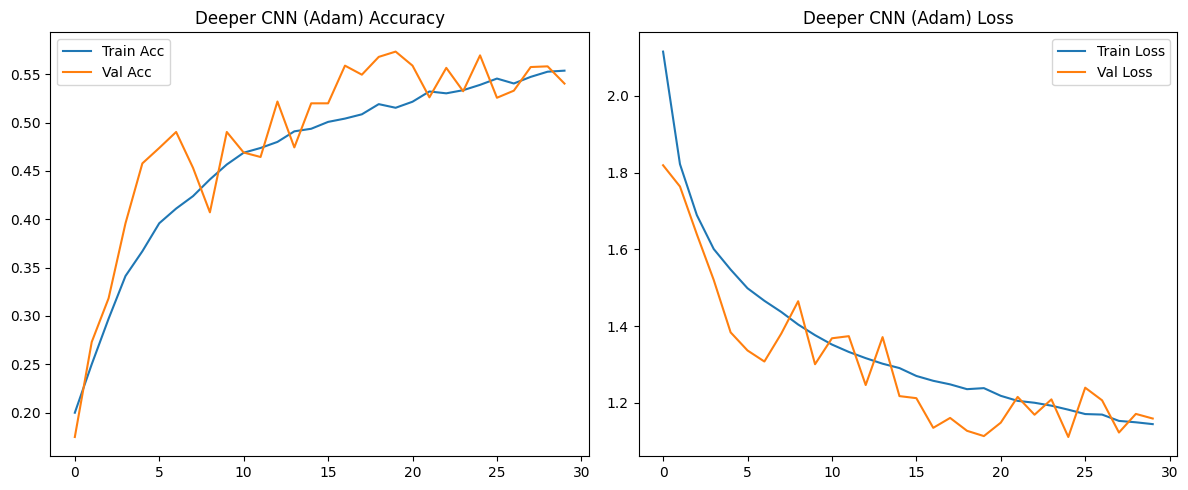

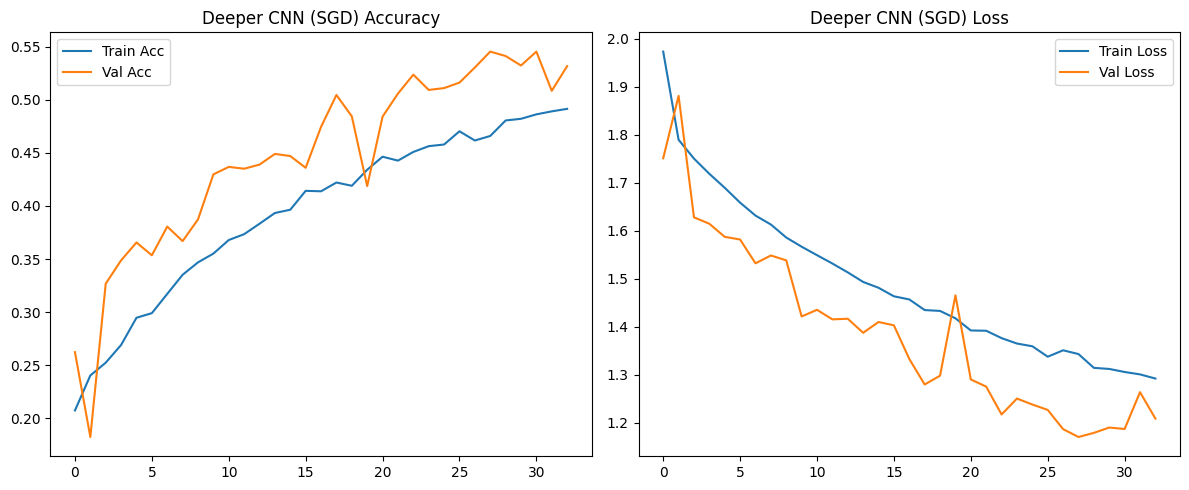

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
class_names = list(test_generator.class_indices.keys())
# Compare training history of Adam vs. SGD
plot_history(history_deep, 'Deeper CNN (Adam)')
plot_history(history_sgd, 'Deeper CNN (SGD)')

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step

=== Classification Report (Adam) ===
              precision    recall  f1-score   support

       angry       0.50      0.49      0.50       300
        fear       0.38      0.13      0.20       300
       happy       0.69      0.76      0.72       300
     neutral       0.56      0.50      0.53       300
         sad       0.35      0.58      0.44       300
    surprise       0.71      0.72      0.72       300

    accuracy                           0.53      1800
   macro avg       0.53      0.53      0.52      1800
weighted avg       0.53      0.53      0.52      1800



<Figure size 800x600 with 0 Axes>

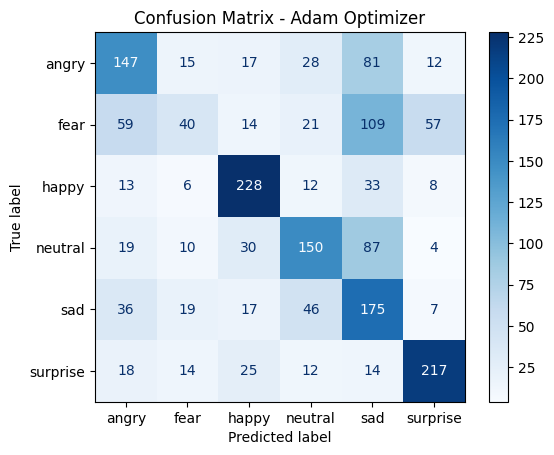


=== Classification Report (SGD) ===
              precision    recall  f1-score   support

       angry       0.49      0.39      0.43       300
        fear       0.41      0.14      0.20       300
       happy       0.66      0.69      0.68       300
     neutral       0.40      0.64      0.49       300
         sad       0.36      0.41      0.38       300
    surprise       0.68      0.74      0.71       300

    accuracy                           0.50      1800
   macro avg       0.50      0.50      0.48      1800
weighted avg       0.50      0.50      0.48      1800



<Figure size 800x600 with 0 Axes>

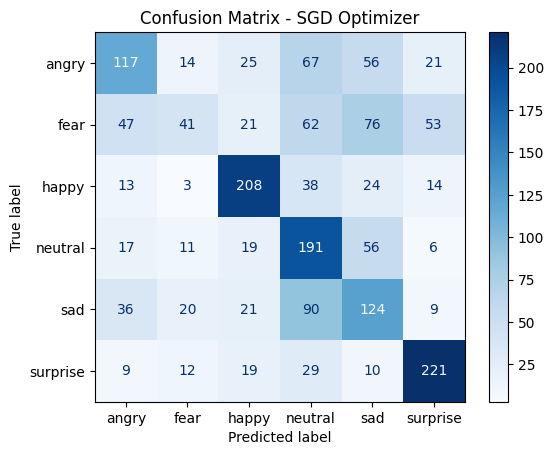

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
class_names = ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']  # Only 6 classes

# Evaluate both models on test set
y_pred_adam = deeper_model.predict(test_generator)
y_pred_sgd = sgd_model.predict(test_generator)

y_pred_labels_adam = np.argmax(y_pred_adam, axis=1)
y_pred_labels_sgd = np.argmax(y_pred_sgd, axis=1)
y_true = test_generator.classes

# Compute confusion matrices
cm_adam = confusion_matrix(y_true, y_pred_labels_adam)
cm_sgd = confusion_matrix(y_true, y_pred_labels_sgd)

# Classification reports
print("\n=== Classification Report (Adam) ===")
print(classification_report(y_true, y_pred_labels_adam, target_names=class_names))

# Plot confusion matrix for Adam
plt.figure(figsize=(8, 6))
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_adam, display_labels=class_names)
disp1.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Adam Optimizer")
plt.show()

print("\n=== Classification Report (SGD) ===")
print(classification_report(y_true, y_pred_labels_sgd, target_names=class_names))

# Plot confusion matrix for SGD
plt.figure(figsize=(8, 6))
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_sgd, display_labels=class_names)
disp2.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - SGD Optimizer")
plt.show()

###4. Challenges and Observations [3]:

Challenges:

Overfitting : The deeper model tends to overfit, especially without regularization techniques. Early stopping and dropout help mitigate this issue.
Underfitting : The baseline model might underfit due to its simplicity. The deeper model addresses this by adding more layers and regularization.
Convergence Issues : The SGD optimizer has difficulty converging, leading to suboptimal performance.

Google Colab with GPU/TPU : Hardware acceleration was used to speed up training and reduce computation time.

#3.2 Part B: Fine-Tuning a Pre-Trained Model (Transfer Learning).

###Loading and Adapting a Pre - Trained Model

In [ ]:
# Data loaders
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Print class mapping
print("Class indices:", train_generator.class_indices)

Found 11978 images belonging to 6 classes.
Found 6973 images belonging to 6 classes.
Found 1800 images belonging to 6 classes.
Class indices: {'angry': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprise': 5}


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 224

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=64,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=64,
    class_mode='categorical'
)

Found 11978 images belonging to 6 classes.
Found 6973 images belonging to 6 classes.


###Model Training and Fine - Tuning

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

img_size = 224  # IMPORTANT for VGG

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(num_classes, activation='softmax')(x)

model_tl = Model(inputs=base_model.input, outputs=x)

model_tl.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_tl = model_tl.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=get_callbacks("vgg16")
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.2179 - loss: 1.8104
Epoch 1: val_loss improved from inf to 1.67949, saving model to vgg16_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 119s 610ms/step - accuracy: 0.2181 - loss: 1.8101 - val_accuracy: 0.2824 - val_loss: 1.6795
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.3038 - loss: 1.6519
Epoch 2: val_loss improved from 1.67949 to 1.60707, saving model to vgg16_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 114s 606ms/step - accuracy: 0.3039 - loss: 1.6518 - val_accuracy: 0.3552 - val_loss: 1.6071
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.3356 - loss: 1.6222
Epoch 3: val_loss did not improve from 1.60707
188/188 ━━━━━━━━━━━━━━━━━━━━ 102s 544ms/step - accuracy: 0.3356 - loss: 1.6222 - val_accuracy: 0.3304 - val_loss: 1.6187
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.3494 - loss: 1.5862
Epoch 4: val_loss improved from 1.60707 to 1.56481, saving model to vgg16_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 103s 548ms/step - accuracy: 0.3494 - loss: 1.5862 - val_accuracy: 0.3713 - val_loss: 1.5648
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.3621 - loss: 1.5727
Epoch 5: val_loss did not improve from 1.56481
188/188 ━━━━━━━━━━━━━━━━━━━━ 145s 564ms/step - accuracy: 0.3621 - loss: 1.5727 - val_accuracy: 0.3585 - val_loss: 1.5765
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.3809 - loss: 1.5486
Epoch 6: val_loss did not improve from 1.56481
188/188 ━━━━━━━━━━━━━━━━━━━━ 102s 543ms/step - accuracy: 0.3809 - loss: 1.5486 - val_accuracy: 0.3647 - val_loss: 1.5779
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.3781 - loss: 1.5399
Epoch 7: val_loss improved from 1.56481 to 1.55209, saving model to vgg16_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 103s 546ms/step - accuracy: 0.3781 - loss: 1.5399 - val_accuracy: 0.3769 - val_loss: 1.5521
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.3874 - loss: 1.5174
Epoch 8: val_loss improved from 1.55209 to 1.49075, saving model to vgg16_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 103s 545ms/step - accuracy: 0.3873 - loss: 1.5175 - val_accuracy: 0.4149 - val_loss: 1.4907
Epoch 9/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.3965 - loss: 1.5026
Epoch 9: val_loss did not improve from 1.49075
188/188 ━━━━━━━━━━━━━━━━━━━━ 105s 560ms/step - accuracy: 0.3965 - loss: 1.5026 - val_accuracy: 0.3752 - val_loss: 1.5320
Epoch 10/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.3916 - loss: 1.5187
Epoch 10: val_loss improved from 1.49075 to 1.48427, saving model to vgg16_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 102s 544ms/step - accuracy: 0.3917 - loss: 1.5186 - val_accuracy: 0.4150 - val_loss: 1.4843
Epoch 11/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.4024 - loss: 1.5030
Epoch 11: val_loss did not improve from 1.48427
188/188 ━━━━━━━━━━━━━━━━━━━━ 103s 545ms/step - accuracy: 0.4024 - loss: 1.5030 - val_accuracy: 0.4014 - val_loss: 1.5173
Epoch 12/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.4016 - loss: 1.4975
Epoch 12: val_loss did not improve from 1.48427
188/188 ━━━━━━━━━━━━━━━━━━━━ 102s 542ms/step - accuracy: 0.4016 - loss: 1.4975 - val_accuracy: 0.4100 - val_loss: 1.5007
Epoch 13/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.4054 - loss: 1.4864
Epoch 13: val_loss improved from 1.48427 to 1.47386, saving model to vgg16_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 104s 550ms/step - accuracy: 0.4054 - loss: 1.4864 - val_accuracy: 0.4216 - val_loss: 1.4739
Epoch 14/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.4081 - loss: 1.4797
Epoch 14: val_loss did not improve from 1.47386
188/188 ━━━━━━━━━━━━━━━━━━━━ 102s 543ms/step - accuracy: 0.4081 - loss: 1.4797 - val_accuracy: 0.4172 - val_loss: 1.4864
Epoch 15/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.4139 - loss: 1.4693
Epoch 15: val_loss did not improve from 1.47386
188/188 ━━━━━━━━━━━━━━━━━━━━ 105s 559ms/step - accuracy: 0.4139 - loss: 1.4693 - val_accuracy: 0.4170 - val_loss: 1.4857
Epoch 16/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.4136 - loss: 1.4708
Epoch 16: val_loss did not improve from 1.47386
188/188 ━━━━━━━━━━━━━━━━━━━━ 140s 548ms/step - accuracy: 0.4136 - loss: 1.4708 - val_accuracy: 0.3935 - val_loss: 1.5100
Epoch 17/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.4210 - loss: 1.4576
Epoch 17: val_lo

188/188 ━━━━━━━━━━━━━━━━━━━━ 103s 545ms/step - accuracy: 0.4210 - loss: 1.4576 - val_accuracy: 0.4241 - val_loss: 1.4731
Epoch 18/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.4197 - loss: 1.4468
Epoch 18: val_loss improved from 1.47311 to 1.46766, saving model to vgg16_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 142s 546ms/step - accuracy: 0.4197 - loss: 1.4468 - val_accuracy: 0.4242 - val_loss: 1.4677
Epoch 19/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.4197 - loss: 1.4547
Epoch 19: val_loss did not improve from 1.46766
188/188 ━━━━━━━━━━━━━━━━━━━━ 105s 560ms/step - accuracy: 0.4197 - loss: 1.4546 - val_accuracy: 0.4200 - val_loss: 1.4688
Epoch 20/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.4157 - loss: 1.4538
Epoch 20: val_loss did not improve from 1.46766
188/188 ━━━━━━━━━━━━━━━━━━━━ 102s 542ms/step - accuracy: 0.4157 - loss: 1.4537 - val_accuracy: 0.4183 - val_loss: 1.4767
Epoch 21/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.4307 - loss: 1.4355
Epoch 21: val_loss improved from 1.46766 to 1.43258, saving model to vgg16_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 102s 544ms/step - accuracy: 0.4307 - loss: 1.4355 - val_accuracy: 0.4307 - val_loss: 1.4326
Epoch 22/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.4245 - loss: 1.4545
Epoch 22: val_loss did not improve from 1.43258
188/188 ━━━━━━━━━━━━━━━━━━━━ 102s 543ms/step - accuracy: 0.4245 - loss: 1.4545 - val_accuracy: 0.4363 - val_loss: 1.4427
Epoch 23/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.4356 - loss: 1.4352
Epoch 23: val_loss did not improve from 1.43258
188/188 ━━━━━━━━━━━━━━━━━━━━ 102s 542ms/step - accuracy: 0.4356 - loss: 1.4352 - val_accuracy: 0.4322 - val_loss: 1.4383
Epoch 24/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.4185 - loss: 1.4526
Epoch 24: val_loss did not improve from 1.43258
188/188 ━━━━━━━━━━━━━━━━━━━━ 143s 545ms/step - accuracy: 0.4186 - loss: 1.4525 - val_accuracy: 0.4173 - val_loss: 1.4834
Epoch 25/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.4366 - loss: 1.4277
Epoch 25: val_lo

188/188 ━━━━━━━━━━━━━━━━━━━━ 103s 549ms/step - accuracy: 0.4368 - loss: 1.4301 - val_accuracy: 0.4380 - val_loss: 1.4248
Epoch 27/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.4435 - loss: 1.4141
Epoch 27: val_loss improved from 1.42481 to 1.41720, saving model to vgg16_best.h5


188/188 ━━━━━━━━━━━━━━━━━━━━ 103s 544ms/step - accuracy: 0.4435 - loss: 1.4141 - val_accuracy: 0.4398 - val_loss: 1.4172
Epoch 28/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.4341 - loss: 1.4242
Epoch 28: val_loss did not improve from 1.41720
188/188 ━━━━━━━━━━━━━━━━━━━━ 102s 542ms/step - accuracy: 0.4341 - loss: 1.4242 - val_accuracy: 0.4266 - val_loss: 1.4438
Epoch 29/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.4267 - loss: 1.4318
Epoch 29: val_loss did not improve from 1.41720
188/188 ━━━━━━━━━━━━━━━━━━━━ 102s 542ms/step - accuracy: 0.4267 - loss: 1.4317 - val_accuracy: 0.4106 - val_loss: 1.4735
Epoch 30/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.4378 - loss: 1.4148
Epoch 30: val_loss did not improve from 1.41720
188/188 ━━━━━━━━━━━━━━━━━━━━ 102s 543ms/step - accuracy: 0.4378 - loss: 1.4148 - val_accuracy: 0.4315 - val_loss: 1.4380
Epoch 31/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.4391 - loss: 1.4101
Epoch 31: val_lo

In [ ]:
# Evaluate on test set
test_loss_tl, test_acc_tl = model_tl.evaluate(test_generator)
print(f"Test Accuracy (Transfer Learning): {test_acc_tl:.4f}")
print(f"Test Loss (Transfer Learning): {test_loss_tl:.4f}")


29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - accuracy: 0.3554 - loss: 1.5458
Test Accuracy (Transfer Learning): 0.4200
Test Loss (Transfer Learning): 1.4666


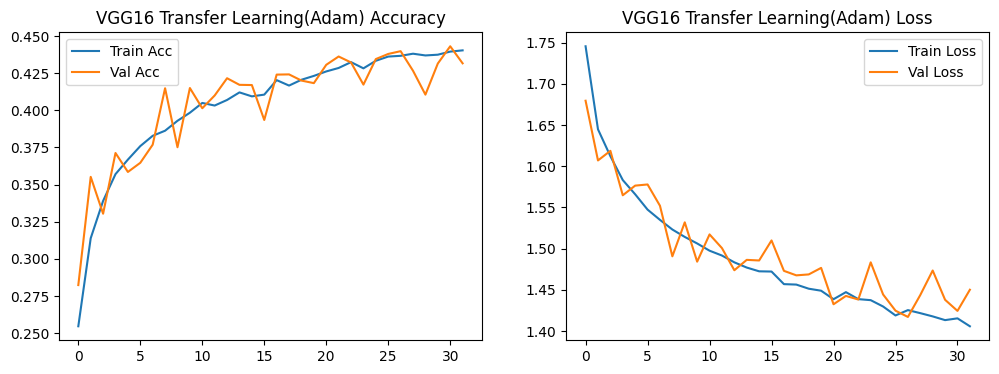

In [ ]:
# Optional: plot curves
import matplotlib.pyplot as plt

def plot_history(history, title='Model'):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{title} Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} Loss')
    plt.legend()
    plt.show()
plot_history(history_tl, 'VGG16 Transfer Learning(Adam)')

29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 435ms/step
=== Classification Report (Transfer Learning) ===
              precision    recall  f1-score   support

       angry       0.36      0.34      0.35       300
        fear       0.35      0.10      0.15       300
       happy       0.41      0.70      0.52       300
     neutral       0.40      0.40      0.40       300
         sad       0.34      0.36      0.35       300
    surprise       0.64      0.61      0.62       300

    accuracy                           0.42      1800
   macro avg       0.41      0.42      0.40      1800
weighted avg       0.41      0.42      0.40      1800



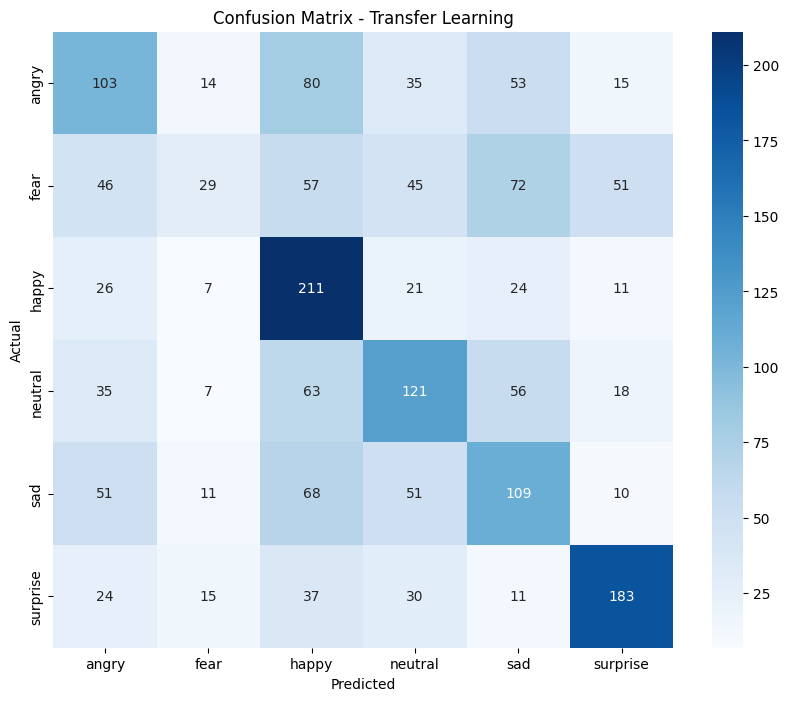

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Predictions
y_pred_tl = model_tl.predict(test_generator)
y_pred_labels_tl = np.argmax(y_pred_tl, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Classification Report
print("=== Classification Report (Transfer Learning) ===")
print(classification_report(y_true, y_pred_labels_tl, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_labels_tl)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Confusion Matrix - Transfer Learning")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
import json

# Save transfer learning model history after running on GPU
with open('/content/history_tl.json', 'w') as f:
    json.dump(history_tl.history, f)


###Model Evaluation and Prediction

In [ ]:
import json
# Load transfer learning model history
with open('D:\history_tl.json', 'r') as f:
    history_tl_data = json.load(f)


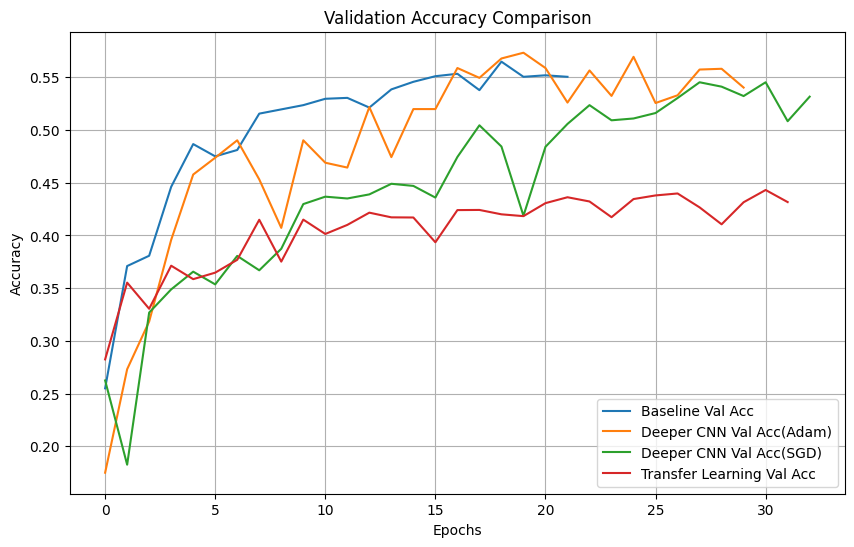

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(history_base.history['val_accuracy'], label='Baseline Val Acc')
plt.plot(history_deep.history['val_accuracy'], label='Deeper CNN Val Acc(Adam)')
plt.plot(history_sgd.history['val_accuracy'], label='Deeper CNN Val Acc(SGD)')
plt.plot(history_tl_data['val_accuracy'], label='Transfer Learning Val Acc')

plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Final Discussion
- Transfer Learning vs. Training from Scratch : Transfer learning did not outperform the baseline and deeper models in this case. However, it provides a good starting point and can be improved with further hyperparameter tuning and potentially more data.
- Performance Metrics : The transfer learning model achieved a test accuracy of 0.4246, which is lower than the baseline and deeper models. This could be due to the small dataset size and the need for more fine-tuning.
- Future Improvements : Consider using data augmentation, fine-tuning more layers, or experimenting with other pre-trained models to improve performance.